In [1]:
import time
import gym_2048
from tensorforce import Agent, Environment
import numpy as np
from matplotlib.pyplot import imshow
%load_ext tensorboard

In [2]:
def invalide_moves_activation(state):
    #retourne mask
    mask_per_coup = []
    for k in range(4):
        try:
            reward = environment._environment.environment.move(k, trial=True)
            mask_per_coup.append(True)
        except:
            mask_per_coup.append(False)

    # liste de coups sans invalid move
    state_mask = dict(state=state,  action_mask=mask_per_coup)
    return state_mask

In [3]:
agent = Agent.load(directory='/Users/jean-bricetonin/code/Valentin_laurent/Year-2048',filename='/Users/jean-bricetonin/code/Valentin_laurent/Year-2048/first save test-2')

In [4]:
environment = Environment.create(
    environment='gym', level='2048-v0', max_episode_timesteps=1000
)

# Defaut hyperparams
agent = Agent.create(
    agent='dqn',
    batch_size=16, # Required by Tensorforce
    update_frequency=4, # Update frequency, TensorForce default : batch_size * 0.25
    environment=environment,
    learning_rate = 0.0001, # (TensorForce default)
    discount = 0.99, # (TensorForce default)
    memory=20000,
    exploration=0.05, # (0 is the TensorForce default)
    target_sync_frequency=4, # (1 is the TensorForce default)
    #summarizer=dict(directory=logs_directory)
)

max_tiles = []
scores = []
start_training_time = time.time()

for episode in range(25):
    state = environment.reset()
    terminal = False
    
    #Checking metrics while training
    state_freeze = state.copy()
    num_updates = 0
    num_moves = 0
    invalid_moves = 0
    start_episode_time = time.time()
    
    while not terminal:
        #mask invalid move
        state = invalide_moves_activation(state)
        #Core
        action = agent.act(states=state)
        state, terminal, reward = environment.execute(actions=action)
        log2_reward = reward if reward <= 0 else np.log2(reward)
        num_updates += agent.observe(terminal=terminal, reward=log2_reward)

        #Number of moves
        num_moves += 1
        
        #Number of invalid moves
        if (state == state_freeze).all():
            invalid_moves += 1
        state_freeze = state.copy()
    
    # Storing score and max tile
    max_tiles.append(environment._environment.environment.Matrix.max())
    scores.append(environment._environment.environment.score)
    if isinstance(episode/10, int):
        print('Episode {}: terminal = {}, updates={}, max_tile={}, valid_moves={}, invalid_moves={}, seconds={}'\
              .format(episode, terminal, num_updates, max_tiles[-1], num_moves-invalid_moves, invalid_moves, round(time.time() - start_episode_time,2)))

#agent.close()
#environment.close()
print("Last 100 episodes mean score: ", np.mean(scores[-100:]))
print("Max tile on last 100 episodes: ", max(max_tiles[-100:]))
print("Total training time (minutes): ", round((time.time() - start_training_time)/60,2))

Last 100 episodes mean score:  1267.68
Max tile on last 100 episodes:  256
Total training time (minutes):  0.67


In [5]:
episode = 25
if episode%50 == 0:
    print('yes')
else:
    print('no')


no


In [52]:
import time

In [116]:
# Evaluate for 100 episodes
def test_agent(agent,n_episode):
    
    n_episode = n_episode
    dico_max_tiles_distribution = {}
    liste_score=[]
    dico_best_worst_episode = {'Worst':[],'Best':[], 'Episode # Worst':[], 'Episode # Best':[]}

    for episode in range(n_episode):
        sum_rewards = 0.0
        states = environment.reset()
        list_states=[]
        internals = agent.initial_internals()
        terminal = False

        while not terminal:
            states = invalide_moves_activation(states)
            actions, internals = agent.act(
                states=states, internals=internals,
                independent=True, deterministic=True
            )
            states, terminal, reward = environment.execute(actions=actions)
            matrix = environment._environment.environment.Matrix
            list_states.append(matrix.copy())
            sum_rewards += reward

        liste_score.append(sum_rewards)

        if sum_rewards >= max(liste_score):
            dico_best_worst_episode['Best'] = list_states
            dico_best_worst_episode['Episode # Best'] = episode
        elif sum_rewards <= min(liste_score):
            dico_best_worst_episode['Worst'] = list_states
            dico_best_worst_episode['Episode # Worst'] = episode

        dico_max_tiles_distribution.setdefault(environment._environment.environment.Matrix.max(),0)
        dico_max_tiles_distribution[environment._environment.environment.Matrix.max()] += 1

    return dico_best_worst_episode, liste_score, dico_max_tiles_distribution


In [121]:
def sort_dico(dico):
    dico_sorted={}
    for k,v in dict(sorted(dico.items())).items():
        k_str = str(k)
        dico_sorted[k_str] = v

    return dico_sorted

def plot_metrics(dico_sorted,rewards):
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Max tile distribution')
    plt.bar(*zip(*dico_sorted.items()))

    plt.subplot(1, 2, 2)
    plt.title('Score distribution')
    sns.histplot(rewards, kde=True)

    print(f'Mean score over the test: {np.mean(rewards)}')
    print(f'Median score over the test: {np.median(rewards)}')
    print(f'Std score over the test: {np.std(rewards)}')
    print(f'Max tile over the test: {max([int(bins) for bins in dico_sorted.keys()])}')

In [118]:
dico_test_BestWorst, dsitrib_score, dico_distrib_tile = test_agent(agent,5)

Mean score over the test: 2785.6
Median score over the test: 2552.0
Std score over the test: 779.0398192647151
Max tile over the test: 256


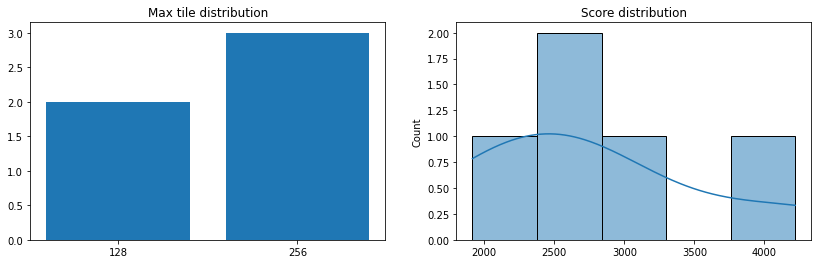

In [122]:
plot_metrics(sort_dico(dico_distrib_tile),dsitrib_score)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt